# Crab Age Regression

**Context:** For a commercial crab farmer knowing the right age of the crab helps them decide if and when to harvest the crabs. Beyond a certain age, there is negligible growth in crab's physical characteristics and hence, it is important to time the harvesting to reduce cost and increase profit.

<br>

**Goal:** The dataset is used to estimate the age of the crab based on the physical attributes. 

<br>

**Feature Description:**
- Sex - Gender of the Crab (Male, Female and Indeterminate)
- Length - Length of the Crab (Feet)
- Diameter - Diameter of the Crab (Feet)
- Height - Height of the Crab (Feet)
- Weight - Weight of the Crab (Ounces)
- Shucked Weight - Weight without the shell (Ounces)
- Viscera Weight - It is weight that wraps around your abdominal organs deep inside body (Ounces)
- Shell Weight - Weight of the Shell (Ounces)
- Age - Age of the Crab (Months)

<br>

**Resources:**
- [Kaggle Challenge](https://www.kaggle.com/competitions/playground-series-s3e16/data?select=train.csv)
- [Original Dataset](https://www.kaggle.com/datasets/sidhus/crab-age-prediction)

In [1]:
# Import Standard Libraries
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import mlflow

from pathlib import Path
from colorama import Style, Fore

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, LearningCurveDisplay, \
                                    learning_curve, ShuffleSplit, GridSearchCV, \
                                    KFold

from sklearn.metrics import mean_squared_error, mean_absolute_error, \
                            mean_absolute_percentage_error, r2_score
from sklearn.ensemble import RandomForestRegressor

from scipy import stats

from xgboost import XGBRegressor

In [2]:
# Define Seaborn theme parameters
theme_parameters =  {
    'axes.spines.right': False,
    'axes.spines.top': False,
    'grid.alpha':0.3,
    'figure.figsize': (16, 6),
    'font.family': 'Andale Mono',
    'axes.titlesize': 24,
    'figure.facecolor': '#E5E8E8',
    'axes.facecolor': '#E5E8E8'
}

# Set the theme
sns.set_theme(style='whitegrid',
              palette=sns.color_palette('deep'), 
              rc=theme_parameters)

In [3]:
# Define Colors
black = Style.BRIGHT + Fore.BLACK
magenta = Style.BRIGHT + Fore.MAGENTA
red = Style.BRIGHT + Fore.RED
blue = Style.BRIGHT + Fore.BLUE
reset_colors = Style.RESET_ALL

# Read Data

In [4]:
# Switch flag for Kaggle Cloud
kaggle = False

# Switch flag for including original dataset
include_original_data = True

In [6]:
# Read training data
if kaggle:
    
    # Read data from Kaggle FS
    train_data = pd.read_csv('/kaggle/input/playground-series-s3e16/data.csv', index_col=0)
    original_data = pd.read_csv('', index_col=0)
    
else:
    
    # Define local data file paths
    train_data_file_path = Path(os.path.abspath('')).parents[1] / 'data' / 'S3E16' / 'crab_age_regression_train.csv'
    test_data_file_path = Path(os.path.abspath('')).parents[1] / 'data' / 'S3E16' / 'crab_age_regression_test.csv'
    original_data_file_path = Path(os.path.abspath('')).parents[1] / 'data' / 'S3E16' / 'crab_age_regression_original.csv'
   
    # Read data
    train_data = pd.read_csv(train_data_file_path, index_col=0)
    test_data = pd.read_csv(test_data_file_path, index_col=0)
    original_data = pd.read_csv(original_data_file_path)

# Exploratory Data Analysis (EDA)

In [10]:
# Define dictionary of data to plot
data_to_plot = {'Train': train_data, 
                'Test': test_data, 
                'Original': original_data}

## Shapes Information

In [11]:
# Print shapes information
print(f'{blue}Data Shapes:'
      f'{blue}\n- Train Data     -> {red}{train_data.shape}'
      f'{blue}\n- Original Data  -> {red}{original_data.shape}'
      f'{blue}\n- Test Data      -> {red}{test_data.shape}\n')

Data Shapes:
- Train Data     -> (74051, 9)
- Original Data  -> (3893, 9)
- Test Data      -> (49368, 8)



## Null Values Information

In [12]:
# Print null values information
print(f'{blue}Data Columns with Null Values:'
      f'{blue}\n- Train Data     -> {red}{train_data.isnull().any().sum()}'
      f'{blue}\n- Original Data  -> {red}{original_data.isnull().any().sum()}'
      f'{blue}\n- Test Data      -> {red}{test_data.isnull().any().sum()}\n')

Data Columns with Null Values:
- Train Data     -> 0
- Original Data  -> 0
- Test Data      -> 0



## Feature Distribution

### Numerical Feature Distribution

In [14]:
# Define raw numerical features
raw_numerical_features = ['Length', 
                          'Diameter', 
                          'Height', 
                          'Weight', 
                          'Shucked Weight', 
                          'Viscera Weight', 
                          'Shell Weight']

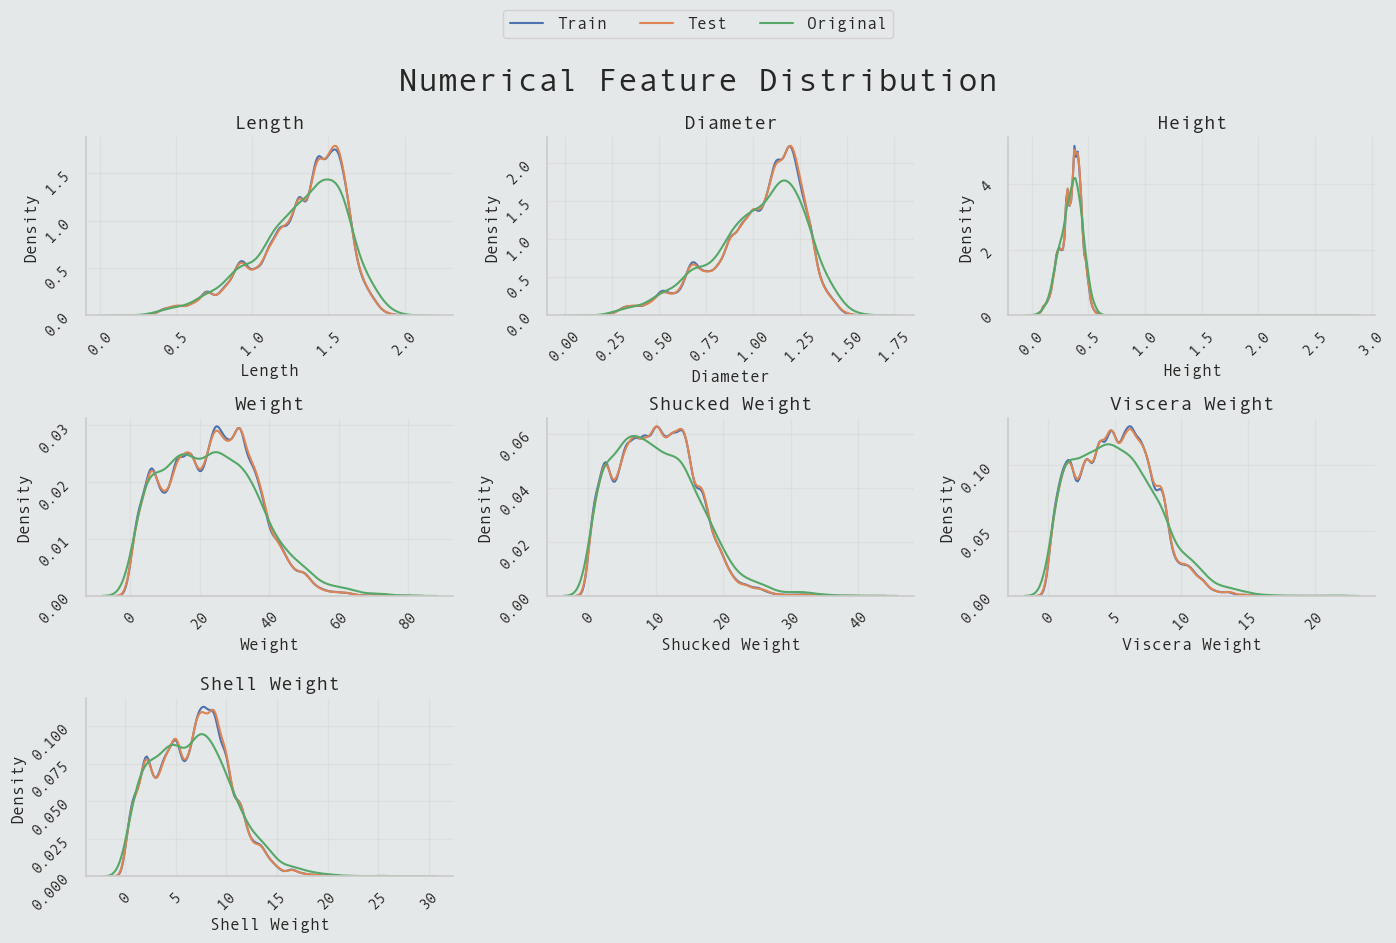

In [18]:
# Plot the KDE of each feature
figure, ax = plt.subplots(3, 3, figsize=(14, 9))
ax = ax.flatten()

# Fetch the data to plot
for index, column_name in enumerate(raw_numerical_features):
    
    # Plot data
    sns.kdeplot(data=train_data[column_name],
                label='Train',
                ax=ax[index])
    
    sns.kdeplot(data=test_data[column_name],
                label='Test',
                ax=ax[index])
    
    sns.kdeplot(data=original_data[column_name],
                label='Original',
                ax=ax[index])
    
    # Set subplot title
    ax[index].set_title(column_name, fontsize=14)
    
    # Set subplot tick rotation
    ax[index].tick_params(labelrotation=45)
    
    # Retrieve legend information
    handles = ax[index].get_legend_handles_labels()[0]
    labels = ax[index].get_legend_handles_labels()[1]
    ax[index].legend().remove()
    
# Remove the empty subplots
figure.delaxes(ax[-1])
figure.delaxes(ax[-2])
    
# Set the legend
figure.legend(handles, 
              labels, 
              loc='center', 
              bbox_to_anchor=(0.5, 1.03), 
              fontsize=12,
              ncol=3)

# Set figure Title
figure.suptitle('Numerical Feature Distribution',
                fontweight='bold',
                fontsize=24)

plt.tight_layout()

- Numerical features have different scales -> Apply Data Standardization
- Numerical features have right or left skewed distributions -> Apply Data Normalization

### Categorical Feature Distribution

#### Sex Distribution

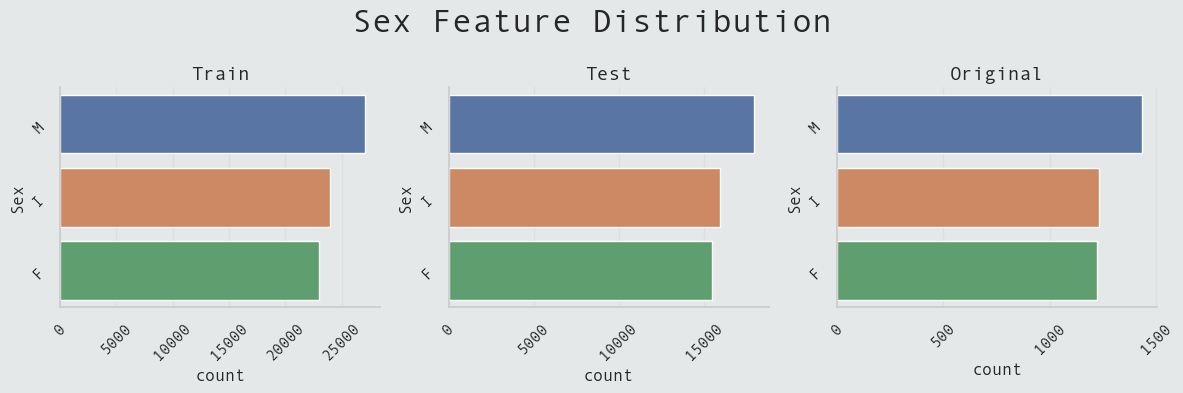

In [23]:
# Plot the countplot for the 'Author' feature
figure, ax = plt.subplots(3, 3, figsize=(12, 4))
ax = ax.flatten()

# Fetch the data to plot
for index, dataset_name in enumerate(data_to_plot.keys()):

    # Plot data
    sns.countplot(data=data_to_plot[dataset_name],
                  y='Sex',
                  label=dataset_name,
                  order=data_to_plot[dataset_name]['Sex'].value_counts().index,
                  ax=ax[index])

    # Set subplot tick rotation
    ax[index].tick_params(labelrotation=45)
    
    # Set subplot title
    ax[index].set_title(f'{dataset_name}', 
                        fontsize=14)

# Set figure Title
figure.suptitle('Sex Feature Distribution',
                fontweight='bold',
                fontsize=24)

plt.tight_layout()

- There are fairly equals samples from all the categories of `Sex`

## Numerical Feature Distribution per Sex

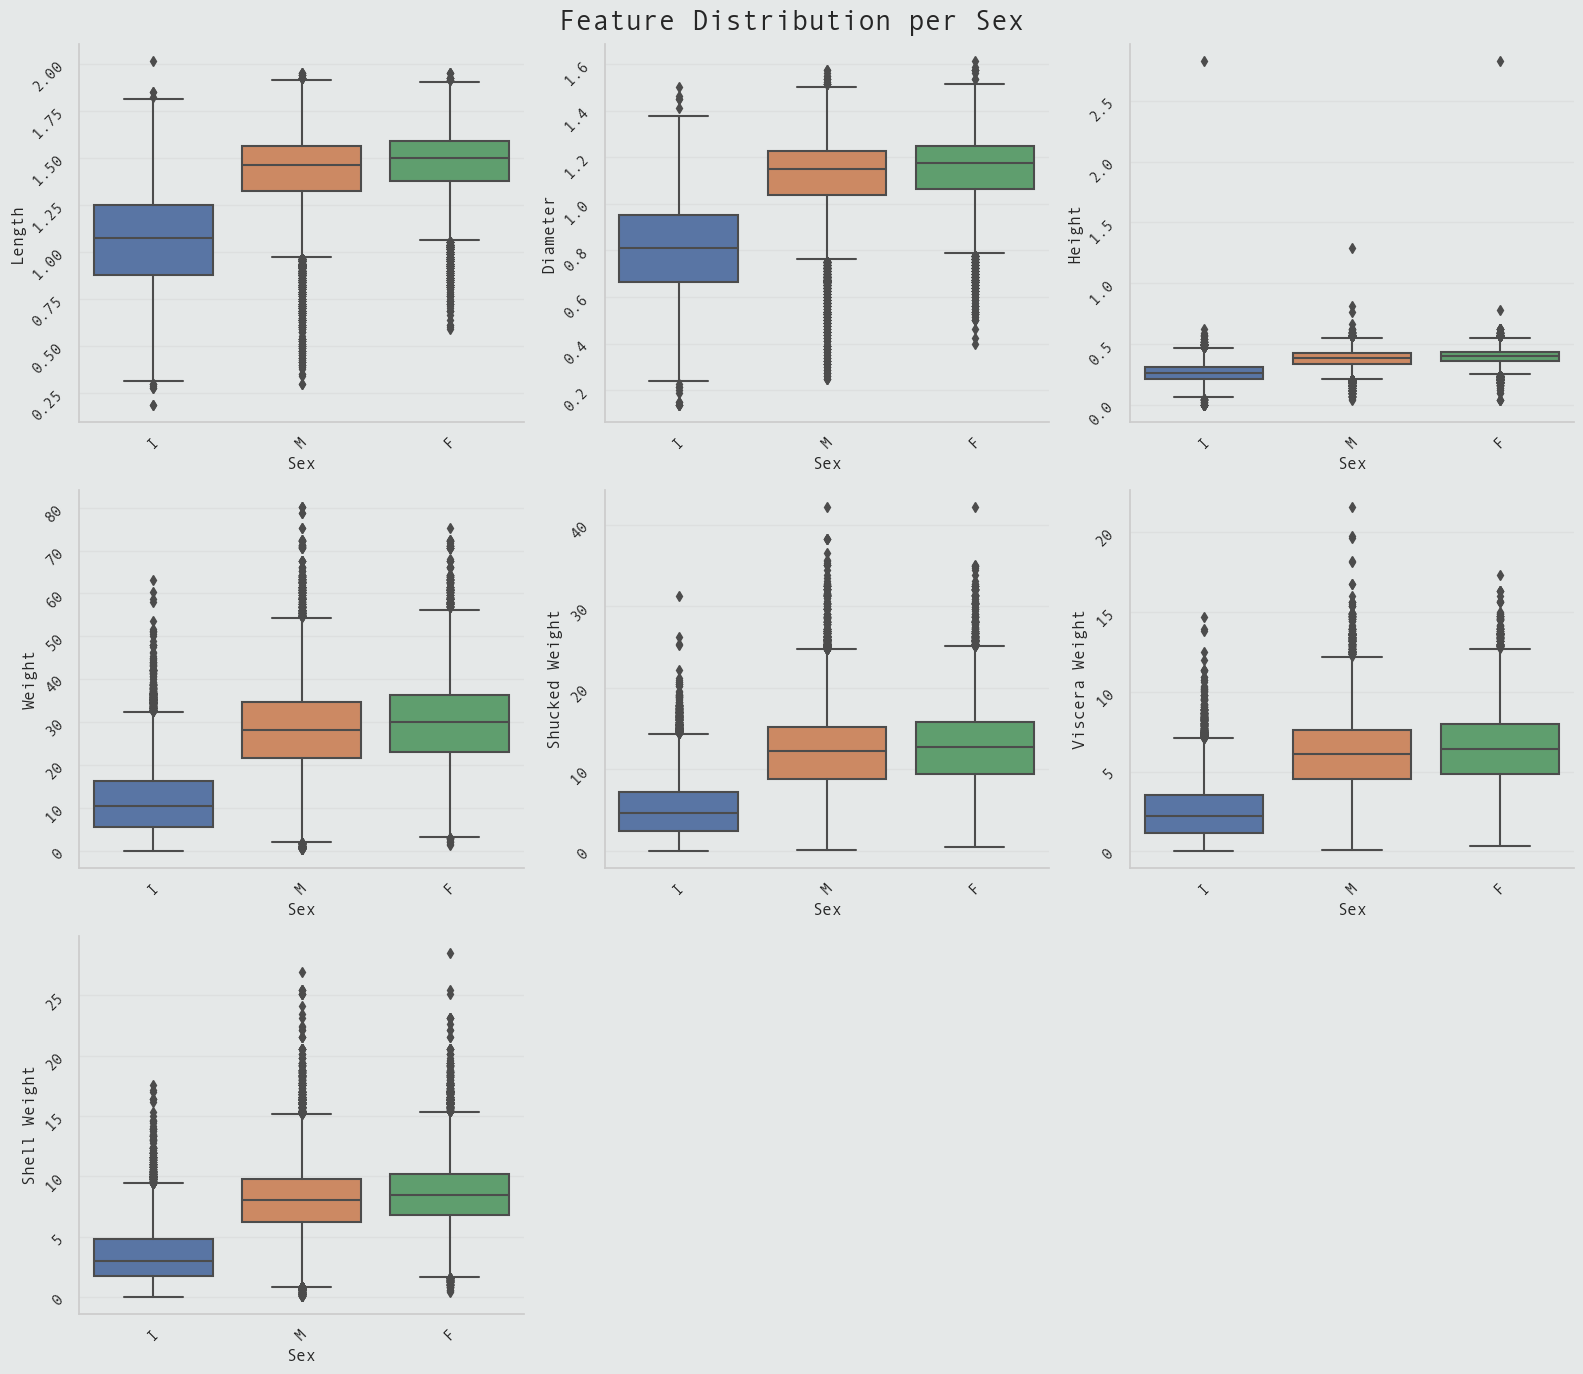

In [28]:
# Define figure and axes
figure, ax = plt.subplots(3, 3, figsize=(16, 14))
ax = ax.flatten()

# Fetch the data to plot
for index, column_name in enumerate(raw_numerical_features):
    
    # Plot data
    sns.boxplot(data=train_data,
                x='Sex',
                y=column_name,
                ax=ax[index])
    
    # Set subplot tick rotation
    ax[index].tick_params(labelrotation=45)
    
# Remove the empty subplots
figure.delaxes(ax[-1])
figure.delaxes(ax[-2])

# Set figure Title
figure.suptitle('Feature Distribution per Sex',
                fontweight='bold',
                fontsize=20)

plt.tight_layout()

- Numerical features vary quite heavily with respect to the `Sex` category. It is required to include `Sex` as a feature

## Label Distribution

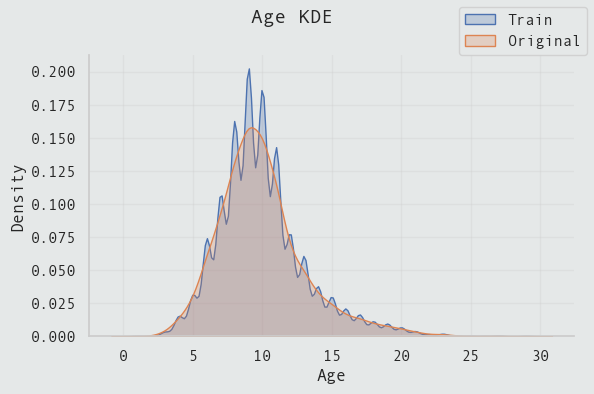

In [24]:
# Define figure and axes
figure, ax = plt.subplots(1, 1, figsize=(6, 4))

# Plot the KDE of label
sns.kdeplot(data=train_data['Age'], 
            fill=True,
            label='Train')

sns.kdeplot(data=original_data['Age'], 
            fill=True,
            label='Original')

# Set figure title
figure.suptitle('Age KDE', fontsize=14)

figure.legend()

plt.tight_layout()

- Train and Original data have the same label distribution

## Pearson Correlation

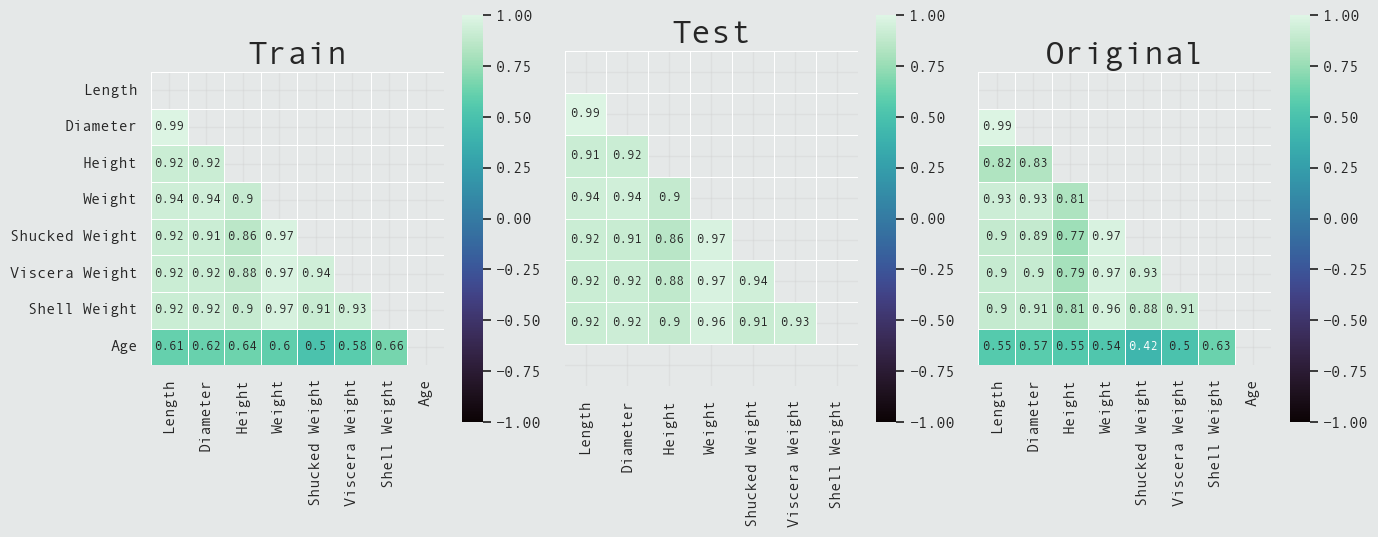

In [34]:
# Define figure and axis
figure, ax = plt.subplots(1, 3, figsize=(14, 6), sharey=True)
ax.flatten()

# Fetch the data to plot
for index, dataset_name in enumerate(data_to_plot.keys()):

    # Compute the correlation matrix
    correlation_matrix = data_to_plot[dataset_name].select_dtypes(include=np.number).corr()
    
    # Generate a mask for the upper triangle
    correlation_mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    
    # Plot the correlation matrix
    sns.heatmap(correlation_matrix, 
                mask=correlation_mask, 
                cmap='mako',
                vmax=1.0, 
                vmin=-1.0, 
                center=0, 
                square=True, 
                linewidths=.5, 
                annot=True,
                annot_kws={'fontsize': 9},
                cbar_kws={"shrink":.8, 'orientation':'vertical'}, 
                ax=ax[index])

    # Set title
    ax[index].set_title(f'{dataset_name}',
                        fontweight='bold')


plt.tight_layout()

- The features related to the weight are very correlated. It is better probably to keep just `Weight`
- Compute the `Volume` by multiplying `Length` x `Diameter` x `Height`

## Conclusions

- Quite a huge dataset. We can apply K-Fold and still have reasonable amount of data for each fold
- Apply Data Standardization
- Apply Data Normalization
- Include `Sex` as feature
- Include only `Weight` as a weight-based feature
- Compute `Volume` by multiplying `Length` x `Diameter` x `Height`

# Data Preparation

## Feature Engineering

In [36]:
class ComputeNumericalEngineeredFeatures(BaseEstimator, TransformerMixin):
    """
    Create a pre-defined set of engineered feature to the input DataFrame
    """
    
    def fit( self, X, y = None ):
        """
        This method is not required for this transformer
        """
        return self
    
    def transform(self, X):
    
        # Create a feature `D_e over pressure`
        X['Volume'] = X['Length'] * X['Diameter'] * X['Height']

        # Save column names
        self.feature_names = X.columns

        return X
    
    def get_feature_names_out(self, feature_names):
        """
        Retrieve the feature names
        """
        return [f'{col}' for col in self.feature_names]